In [241]:
%load_ext autoreload
%autoreload 1
%aimport vae
%aimport distributions
%aimport distribution_metrics
%aimport y_utils
%aimport samplers
%aimport utilities
%aimport rnvp
%aimport flow_trainer
from utilities import *
from y_utils import *
from vae import VAE, VAETrainer, get_filename
from samplers import *
from distributions import Banana, Funnel, create_gaussian_lattice, create_random_gaussian_mixture, get_mode_coverage
from distribution_metrics import *
import torch
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
from time import time
from tqdm import tqdm
from collections import defaultdict
from math import ceil
import seaborn as sns
from rnvp import RNVP
from flow_trainer import FlowTrainer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
device: cpu


In [93]:
# Target 1
lattice_shape = (5, 5)
D = len(lattice_shape)
mode_variance = 0.001
target = create_gaussian_lattice(lattice_shape, 1, mode_variance, device=device)
target_name = f'gaussian_lattice{lattice_shape}_var{mode_variance}'
target_friendly_name = f'{"x".join(map(str, lattice_shape))} Gaussian Lattice'

In [29]:
# Target 2
target = Funnel(dim=32, device=device, a=2)

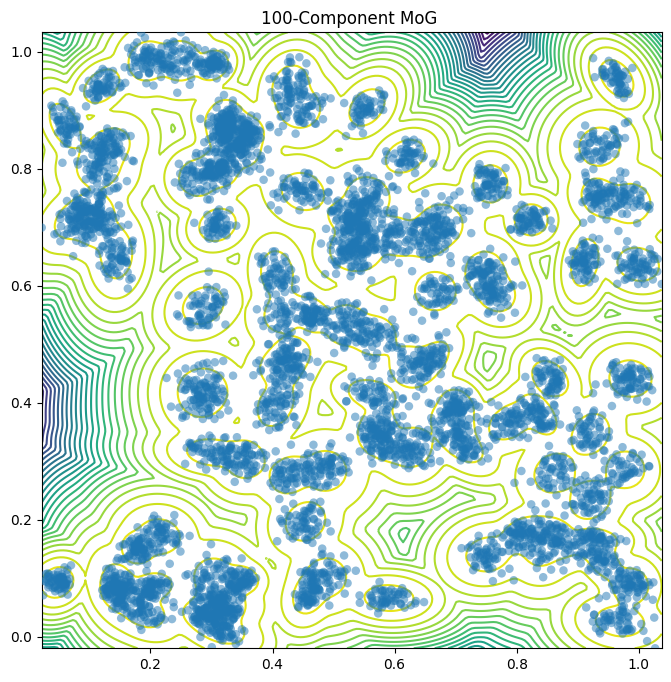

In [77]:
# Target 3
mean_lim = np.array([0, 1])
seed = 43
n_components = 100
D = 2
variance_lim = (0.0001, 0.0005)
target = create_random_gaussian_mixture(dim=D, n_components=n_components, mean_lim=mean_lim, variance_lim=variance_lim, device=device, seed=seed)
target_name = f'mog{n_components}_{D}d_vlim{variance_lim}_seed{seed}'
target_friendly_name = f'{n_components}-Component MoG'


def plot_target(N=4000, xlim=None, ylim=None, levels=30):
    plot_lim = (-0.1, 1.1)
    d = 200

    # Implementation of torch.distributions.mixture_same_family.sample() causes MemoryOverflow without batched sampling
    target_sample = sample_by_batches(target, N, batch_size=1024)
    
    fig, ax = plt.subplots(figsize=(8, 8))

    # contour plot
    if D == 2:
        if xlim is None:
            xlim = (target_sample[:, 0].min().item(), target_sample[:, 0].max().item())
        if ylim is None:
            ylim = (target_sample[:, 1].min().item(), target_sample[:, 1].max().item())
        x = torch.linspace(*xlim, d)
        y = torch.linspace(*ylim, d)
        X, Y = torch.meshgrid(x, y, indexing='ij')
        points = torch.vstack((X.ravel(), Y.ravel()))
        Z = target.log_prob(points.T.to(device)).reshape(d, d)
        ax.contour(to_numpy(X), to_numpy(Y), to_numpy(Z), levels=levels)
        ax.set_xlim(*xlim)
        ax.set_ylim(*ylim)
    
    if D > 2:
        proj_dims = (0, 1)
        target_sample = target_sample[:, proj_dims]
    ax.scatter(*pl(target_sample), zorder=4, alpha=0.5, s=150, edgecolors='none', marker='.')
    ax.set_title(f'{target_friendly_name} {" (Projection)" if D > 2 else ""}')


plot_target(N=6_000)
torch.cuda.empty_cache()

In [94]:
x_train = target.sample((16_384,))

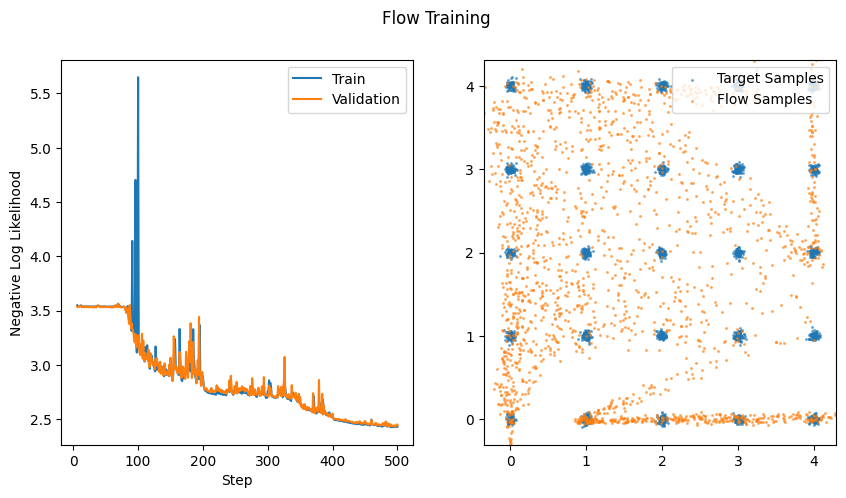

Epoch 500
	Train Loss: 2.4299
	Validation Loss: 2.4461
	Learning rate: 0.0020000000000000005
CPU times: user 9min 45s, sys: 8.26 s, total: 9min 53s
Wall time: 1min 24s


In [195]:
%%time
flow = RNVP(num_blocks=20, dim=2, device=device)
print('Flow parameters:', count_parameters(flow))
optimizer = torch.optim.SGD(flow.parameters(), lr=0.05, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.2, step_size=200)
flow_trainer = FlowTrainer(flow, target, optimizer=optimizer, scheduler=scheduler, batch_size=2048, device=device)
flow_trainer.fit(x_train, n_epochs=500, plot_interval=10)

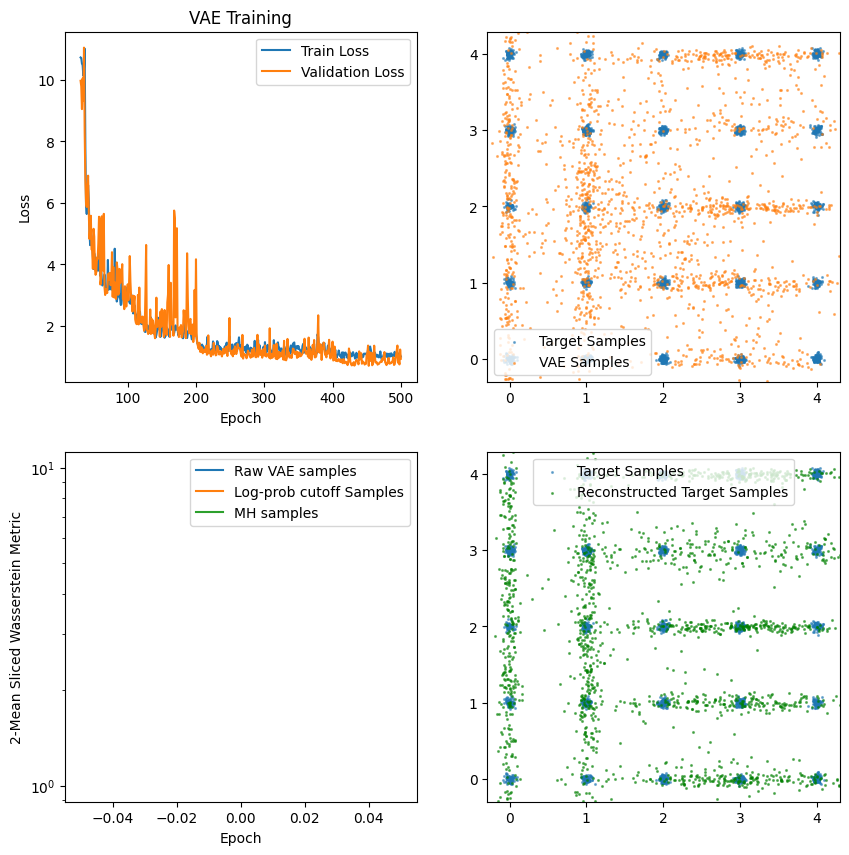

Epoch 500
	Train loss: 1.0053
	Validation loss: 0.9359
	Learning rate: 0.0020000000000000005
CPU times: user 7min 29s, sys: 8.41 s, total: 7min 37s
Wall time: 1min 17s


In [210]:
%%time

hidden_dims = (5, 5, 5, 5, 5, 5, 6)
vae = VAE(
    data_dim=2,
    hidden_dims=hidden_dims,
    latent_dim=10,
    device=device
) 
print('VAE parameters:', count_parameters(vae))
optimizer = torch.optim.SGD(vae.parameters(), lr=0.05, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.2, step_size=200)
trainer = VAETrainer(vae, target, batch_size=2048, no_kl_penalty_epochs=30, kl_annealing_epochs=180, optimizer=optimizer, scheduler=scheduler, device=device)
trainer.fit(x_train, n_epochs=500, plot_interval=10)

In [223]:
metric = SlicedDistributionMetric(WassersteinMetric1d(), D)
N = 3000

L = 512
beta = 1
vae_log_ml_estimator = lambda x : vae.iw_log_marginal_estimate(x, L=L, beta=beta, batch_L=64)
cutoff_log_prob = target.log_prob(x_train).quantile(0)

In [226]:
vae_samples = vae.sample((N,))
cut_vae_acc_rate, cut_vae_samples = log_prob_cutoff_filter(target, vae_samples, cutoff_log_prob, return_indicies=False)
mh_vae_acc_rate, mh_vae_samples = metropolis_hastings_filter(target, cut_vae_samples, vae_log_ml_estimator, max_density_ratio=20, n_estimates=10, return_indicies=False)

flow_samples = flow.sample((N,))
cut_flow_acc_rate, cut_flow_samples = log_prob_cutoff_filter(target, flow_samples, cutoff_log_prob, return_indicies=False)
mh_flow_acc_rate, mh_flow_samples = metropolis_hastings_filter(target, cut_flow_samples, flow.log_prob, return_indicies=False)

MH discarded 0 outlier(s)


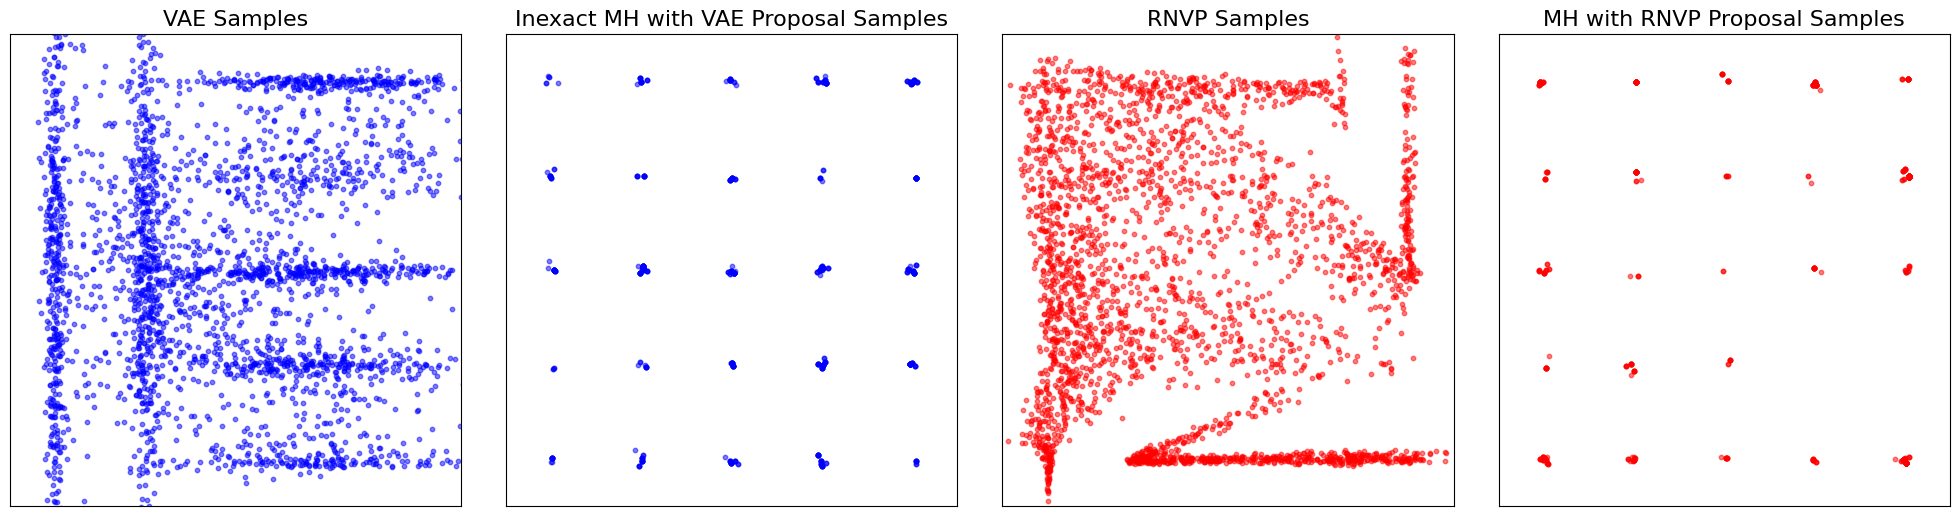

In [240]:
def sample_scatter(self, sample, **kwargs):
    return self.scatter(*pl(sample[:, (0, 1)]), alpha=0.5, s=10, **kwargs)
mpl.axes.Axes.sample_scatter = sample_scatter

fontsize = 16
fig, axs = plt.subplots(figsize=(20, 5.5), ncols=4, nrows=1)
# fig.suptitle('Exact and Inexact Adaptive Proposal Metropolis-Hastings Comparison')
axs[0].sample_scatter(vae_samples, label='VAE', color='blue')
axs[0].set_title('VAE Samples', fontsize=fontsize)
axs[1].sample_scatter(mh_vae_samples, label='VAE + MH', color='blue')
axs[1].set_title('Inexact MH with VAE Proposal Samples', fontsize=fontsize)
axs[2].sample_scatter(flow_samples, label='RNVP', color='red')
axs[2].set_title('RNVP Samples', fontsize=fontsize)
#axs[0].set_xlim(axs[1].get)
axs[0].set_ylim(-1, 5)
axs[2].set_xlim(-1, 5)
axs[2].set_ylim(-1, 5)
axs[3].sample_scatter(mh_flow_samples, label='RNVP + MH', color='red')
axs[3].set_title('MH with RNVP Proposal Samples', fontsize=fontsize)
plt.tight_layout()
for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(-0.5, 4.5)
    ax.set_ylim(-0.5, 4.5)